In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
import category_encoders as ce
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import  balanced_accuracy_score
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier

In [82]:
# load train and validation datasets
train_data=pd.read_csv('https://github.com/goitacademy/MACHINE-LEARNING-NEO/blob/main/competition/final_proj_data.csv?raw=true')
valid_data=pd.read_csv('https://github.com/goitacademy/MACHINE-LEARNING-NEO/blob/main/competition/final_proj_test.csv?raw=true')
submission_data=pd.read_csv('https://github.com/goitacademy/MACHINE-LEARNING-NEO/blob/main/competition/final_proj_sample_submission.csv?raw=true')

In [83]:
# observe train data 
train_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,y
0,NaN,NaN,NaN,NaN,NaN,812.0,14.0,NaN,NaN,NaN,NaN,NaN,1252.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,195.0,NaN,0.0,40.0,NaN,NaN,286.96,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4850466.0,NaN,NaN,...,KXMrEyXXnK,g62hiBSaKg,SEuy,taul,1K8T,IvdZ,fhk21Ss,Pkku4gO,pbHkKHa,smXZ,4MV4,9_Y1,SkZj,VpdQ,itlM,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,WsRVNrF85oPU_,NaN,E4QF4eX,NaN,11pRpOD,G8WR,cJvF,AU8_WTd,4UxGlow,zCkv,catzS2D,jySVZNlOJy,NaN,xG3x,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86,NaN,0
1,NaN,NaN,NaN,NaN,NaN,2688.0,7.0,NaN,NaN,NaN,NaN,NaN,8820.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364.0,455.0,NaN,4.0,288.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,132072.0,NaN,NaN,...,8Knvyx875g,2Knk1KF,SEuy,taul,1K8T,lK27,eQgnKxT,Hz673939hbJdw,ELe4G18,smXZ,sbhw,9_Y1,MBhA,VpdQ,lVqb,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,kfKvbJ9,NaN,11pEY2j,5smi,UYBR,AU8pNoi,GpvRJ5l,oslk,i06ocsg,LM8l689qOp,NaN,kG3k,WqMG,RAYp,55YFVY9,mj86,NaN,0
2,NaN,NaN,NaN,NaN,NaN,1015.0,14.0,NaN,NaN,NaN,NaN,NaN,1784.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,170.0,NaN,2.0,40.0,NaN,NaN,294.48,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3223524.0,NaN,NaN,...,MfKrEyQtC3,RO12,SEuy,taul,1K8T,487l,iJzviRg,76j2P_OLn0,pOtdZA9,smXZ,7KBn,9_Y1,SkZj,VpdQ,hAFG,7M47J5GA0pTYIFxg5uy,kIsH,NaN,g5HH,L84s,cOJGGr4F_wga1,NaN,3_oHWGU,NaN,kq0mb4H,8m7I,cJvF,FzaX,ch2oGfM,zCkv,P6pu4Vl,LM8l689qOp,NaN,kG3k,Aoh3,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,168.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,30.0,NaN,0.0,0.0,NaN,NaN,644.24,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2135430.0,NaN,NaN,...,Qu0qrQKzJV,RO12,NaN,taul,1K8T,487l,3cunsla,ZIX6Y9cVy5,NaN,NaN,6lcF,9_Y1,15m3,09_Q,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,7Wwz9n7,d4ij,cJvF,FzaX,kH5mFX7,oslk,BNrD3Yd,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,14.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,45.0,NaN,0.0,0.0,NaN,NaN,239.84,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3110400.0,NaN,NaN,...,DHerjIKQ76,RO12,NaN,taul,1K8T,YPhp,65ylkJq,glRbITbnHQ,NaN,NaN,UCEj,9_Y1,7WNq,VpdQ,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJtVhC,NEOV,cJvF,FzaX,x_lYlW4,oslk,3B1QowC,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,0


In [84]:
# observe validation data 
valid_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,819.0,7.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,200.0,NaN,2.0,56.0,NaN,NaN,403.36,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4800036.0,NaN,NaN,...,NaN,75lTmBtFkL,rEUOq2QD1qfkRr6qpua,NaN,taul,1K8T,F9g8,fhk21Ss,GVWDufEPyV,3VuKz0_,NaN,GHne,9_Y1,c2JP,VpdQ,hAFG,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,oOT00mkwDoEFW,NaN,XZ6TpvF,NaN,pMW8rnA,6ITF,cJvF,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,ELof,rgKb,ZI9m,ib5G6X1eUxUn6,am7c,NaN
1,NaN,NaN,NaN,NaN,NaN,3192.0,28.0,NaN,NaN,NaN,NaN,NaN,3864.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,475.0,NaN,8.0,288.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,51282.0,NaN,NaN,...,NaN,1YVgUHXZeb,RO12,NaN,taul,1K8T,0Xwj,Ml6kiFp,S85OeCBjSz,NaN,NaN,14hG,HLqf,8BBI,09_Q,43pnToF,me75fM6ugJ,sBgB,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,mAjbk_S,RRN_,UYBR,FzaX,k5O88FJ,oslk,QkgQQMs,LM8l689qOp,NaN,NaN,453m,RAYp,F2FyR07IdsN7I,am7c,NaN
2,NaN,NaN,NaN,NaN,NaN,756.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,195.0,NaN,2.0,40.0,NaN,NaN,402.24,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3462336.0,NaN,NaN,...,NaN,cFHt0GoOh3,RO12,NaN,taul,1K8T,wGW5,Wq69B7S,z7GH4Up,NaN,NaN,dK_l,9_Y1,rGJy,VpdQ,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kZJyVg2,c4pP,UYBR,FzaX,h72uX8Z,oslk,bxCQb98,jySVZNlOJy,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,3892.0,21.0,NaN,NaN,NaN,NaN,NaN,5192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.0,190.0,NaN,0.0,8.0,NaN,NaN,212.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,7331880.0,NaN,NaN,...,NaN,m9SrEy7Rm6,RO12,NaN,taul,1K8T,JLbT,4JEMGuV,oQ173939hSRjL,YtLixTf,NaN,zqqA,9_Y1,X8zP,VpdQ,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,xdDXvoB,NaN,mAjbk_S,fgNW,UYBR,FzaX,VA_88FJ,oslk,0JeRt72,M_8D,NaN,ELof,Aoh3,RAYp,F2FyR07IdsN7I,mj86,NaN
4,NaN,NaN,NaN,NaN,NaN,672.0,7.0,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,180.0,NaN,2.0,64.0,NaN,NaN,322.64,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,381480.0,NaN,NaN,...,NaN,BQavyxLp3Z,RO12,NaN,taul,1K8T,lK27,32pCIek,JQFeOYK,FWqY20R,NaN,YqMO,9_Y1,_r21,VpdQ,kxE9,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,jrs8zOR,NaN,XTbPUYD,dvCm,UYBR,FzaX,FB4YlW4,oslk,0p8OTZB,LM8l689qOp,NaN,ELof,xb3V,RAYp,F2FyR07IdsN7I,mj86,NaN


In [85]:
# observe submission data
submission_data.head()

,index,y
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [86]:
# observe data types and missed data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 231 entries, Var1 to y
dtypes: float64(191), int64(2), object(38)
memory usage: 17.6+ MB


In [87]:
# check for missed values
train_data.isna().mean().sort_values(ascending=False)

Var20     1.0
Var175    1.0
Var42     1.0
Var32     1.0
Var31     1.0
         ... 
Var198    0.0
Var196    0.0
Var195    0.0
Var113    0.0
y         0.0
Length: 231, dtype: float64

In [88]:
# drop rows in which missed values reach more than 35%
columns_to_drop=train_data.isna().mean().lt(0.35)
train_data_cut = train_data[train_data.columns[columns_to_drop]]
train_data_cut.shape

(10000, 68)

In [89]:
# get dataset statistics
train_data_cut.describe()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,y
count,8980.000000,8995.000000,8995.000000,8980.000000,9080.000000,8640.000000,9080.000000,9080.000000,9080.000000,9.080000e+03,9080.000000,10000.000000,8995.000000,10000.00000,8995.000000,9.080000e+03,9080.000000,8.980000e+03,9080.000000,9080.00000,8640.000000,9080.000000,1.000000e+04,8980.000000,9080.000000,8.995000e+03,7220.000000,9080.000000,9.080000e+03,9.080000e+03,8995.000000,9080.000000,8980.000000,8.640000e+03,9.080000e+03,9080.000000,9.080000e+03,9080.000000,9080.000000,10000.00000
mean,1340.916258,6.860700,1312.861812,240.702895,297.810573,4.558333,98.824670,225.037534,0.740639,2.591752e+06,0.162555,3.538075,15.005336,68.92840,101.547082,1.481489e+06,0.490639,1.028155e+05,21.181167,8.65859,64.139815,68.866960,-1.385472e+05,913.434855,62.597577,2.776015e+04,-1.217175,3.403524,2.269244e+06,4.317543e+05,1395.598666,0.056828,11.843318,2.889531e+05,6.164799e+06,39.204405,4.839801e+05,0.004846,0.586674,0.13050
std,2380.516758,6.300994,2814.738176,553.289430,688.436748,9.232289,215.059736,102.007658,3.075834,3.027801e+06,1.611381,2.038409,10.173838,53.97898,296.598152,1.856475e+06,2.070867,1.070764e+05,98.332477,19.89187,176.246791,155.575284,7.742025e+05,1925.708454,239.140170,8.835715e+04,22.918876,9.842115,2.439393e+06,5.996748e+05,3125.800873,0.633419,12.003779,7.013198e+05,4.341391e+06,92.790289,8.499511e+05,0.098332,2.470885,0.33687
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000641,9.000000,4.00000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,-8.306560e+06,0.000000,0.000000,0.000000e+00,-32.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.00000
25%,523.250000,0.000000,0.000000,112.000000,135.000000,0.000000,16.000000,166.560000,0.000000,8.553000e+03,0.000000,1.755661,9.000000,24.00000,0.000000,8.685800e+04,0.000000,1.635252e+04,0.000000,0.00000,24.000000,16.000000,-1.759983e+05,425.000000,6.000000,2.610000e+02,-22.000000,0.000000,2.208275e+05,2.885650e+04,0.000000,0.000000,0.000000,0.000000e+00,1.218036e+06,10.000000,0.000000e+00,0.000000,0.000000,0.00000
50%,861.000000,7.000000,244.000000,144.000000,180.000000,2.000000,48.000000,220.080000,0.000000,1.295544e+06,0.000000,3.569857,9.000000,54.00000,7.000000,8.565160e+05,0.000000,7.198034e+04,10.000000,4.00000,32.000000,40.000000,3.113208e+04,560.000000,30.000000,6.570000e+03,4.000000,0.000000,1.475678e+06,2.059030e+05,235.000000,0.000000,9.000000,4.622100e+04,8.080220e+06,22.000000,1.306890e+05,0.000000,0.000000,0.00000
75%,1428.000000,7.000000,1740.000000,232.000000,285.000000,6.000000,120.000000,266.400000,0.000000,4.633318e+06,0.000000,5.294275,18.000000,106.00000,91.000000,2.294128e+06,0.000000,1.804276e+05,25.000000,10.00000,64.000000,72.000000,1.502915e+05,885.000000,72.000000,3.185550e+04,10.000000,0.000000,3.607945e+06,5.996230e+05,1380.000000,0.000000,18.000000,3.777690e+05,1.036812e+07,42.000000,6.127350e+05,0.000000,0.000000,0.00000
max,76195.000000,35.000000,97364.000000,20708.000000,25885.000000,212.000000,7216.000000,2434.240000,60.000000,1.814400e+07,72.000000,6.999786,99.000000,264.00000,13783.000000,1.935360e+07,33.000000,1.352685e+06,4690.000000,704.00000,7456.000000,4592.000000,8.768320e+06,70265.000000,9456.000000,3.890952e+06,68.000000,112.000000,1.446940e+07,5.159340e+06,49290.000000,18.000000,81.000000,1.693440e+07,1.387516e+07,3416.000000,1.451520e+07,2.000000,49.000000,1.00000


In [90]:
# drop abnormal values from dataset
zscore_dataset=train_data_cut.select_dtypes(include=np.number)
out=(zscore_dataset.apply(lambda x: np.abs(zscore(x, nan_policy='omit')).ge(3)).astype(int).mean(1))
out_ind=np.where(out>0.3)[0]
train_data_cut=train_data_cut.drop(out_ind)
train_data_cut.shape

(9995, 68)

In [91]:
valid_data_cut = valid_data[valid_data.columns[columns_to_drop[:-1]]]
valid_data_cut.shape

(2500, 67)

In [92]:
# split on train and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    train_data_cut.drop('y', axis=1), 
    train_data_cut['y'], 
    test_size=0.2, 
    random_state=42)

In [93]:
cat_pipeline=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',ce.WOEEncoder())
])

In [94]:
# create numerical features Pipeline
num_pipeline=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
])

In [95]:
# create columns transformer
col_processor=(ColumnTransformer(transformers=[
    ('num',num_pipeline,make_column_selector(dtype_exclude='object')),
    ('cat',cat_pipeline,make_column_selector(dtype_include='object')),],
    n_jobs=1,
    verbose_feature_names_out=False).set_output(transform='pandas'))

In [96]:
# check target value distribution
y_train.value_counts(normalize=True)

y
0    0.87056
1    0.12944
Name: proportion, dtype: float64

In [97]:
# perform target value classes balancing
smote=SMOTE(random_state=42)

In [98]:
# create AdaBoost Classifier model
ada_model=AdaBoostClassifier(random_state=42) 

pipe_model=Pipeline(steps=[
    ('col_processor',col_processor),
    ('scaler',PowerTransformer().set_output(transform='pandas')),
    ('smote',smote),
    ('model',ada_model)
])


final_model=pipe_model.fit(X_train,y_train)

prd=final_model.predict(X_test)

bal_accuracy_score=balanced_accuracy_score(y_test, prd)

print(f'Accuracy: {bal_accuracy_score:.1%}')

/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 74.5%


In [99]:
# get cross validation scores
X=pd.concat([X_train, X_test], axis=0)
y=pd.concat([y_train, y_test], axis=0)

cv_results =cross_val_score(estimator=pipe_model,
    X=X,
    y=y,
    cv=5,
    scoring='balanced_accuracy',
    verbose=1)

acc_cv=cv_results.mean()

print(f'Cross Validation Accuracy: {acc_cv:.1%}')

/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to ci

Cross Validation Accuracy: 75.6%


Text(0.5, 1.0, 'Feature Importance Scores')

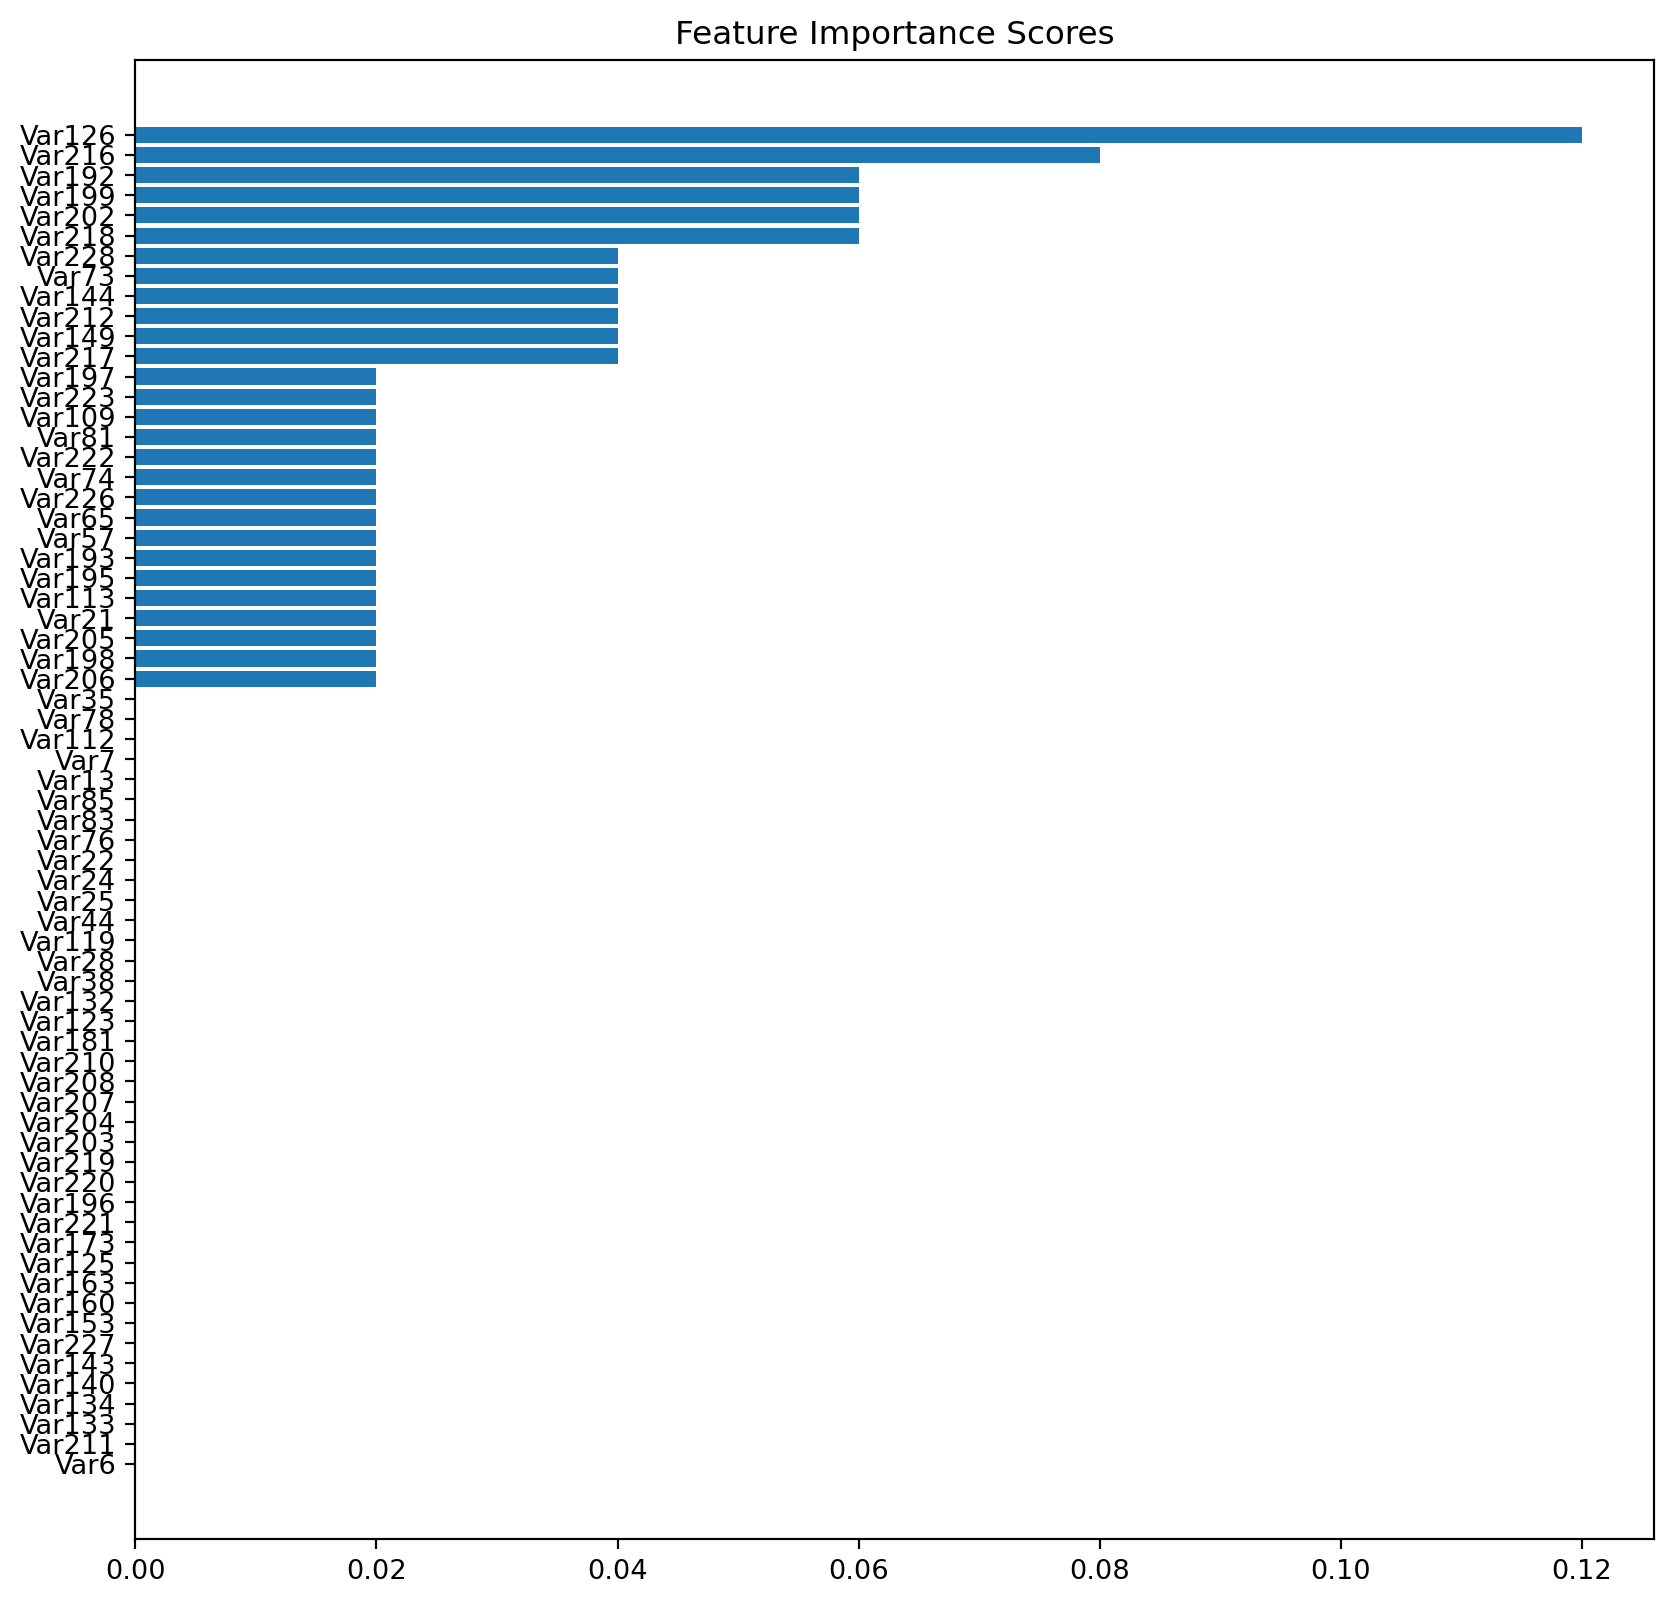

In [100]:
# define feature importance in AdaBoost model
plt.figure(figsize=(10,10), dpi=196)
feat_importance_scores=pd.Series(data=final_model._final_estimator.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.barh(np.arange(len(feat_importance_scores)), feat_importance_scores)
plt.yticks(np.arange(len(feat_importance_scores)), feat_importance_scores.index)
plt.title('Feature Importance Scores')

In [101]:
# get list of the most important features
data_array=feat_importance_scores.sort_values(ascending=False).index.values
important_features=data_array[:13]
important_features

array(['Var126', 'Var216', 'Var192', 'Var199', 'Var202', 'Var218',
       'Var144', 'Var217', 'Var149', 'Var212', 'Var73', 'Var228', 'Var57'],
      dtype=object)

In [102]:
# train AdaBoostClassifier model with only important features
X_train_cutted=X_train[important_features]
X_test_cutted=X_test[important_features]


final_model_cut=pipe_model.fit(X_train_cutted,y_train)

prd_cut=final_model_cut.predict(X_test_cutted)

bal_accuracy_score_cut=balanced_accuracy_score(y_test, prd_cut)

print(f'Accuracy AdaBoost with only important features: {bal_accuracy_score_cut:.1%}')

/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy AdaBoost with only important features: 76.7%


In [103]:
# get cross validation scores with only important features
X_cutted=pd.concat([X_train_cutted, X_test_cutted], axis=0)

cv_results_cut =cross_val_score(estimator=pipe_model,
    X=X_cutted,
    y=y,
    cv=5,
    scoring='balanced_accuracy',
    verbose=1)

acc_cv_cut=cv_results_cut.mean()

print(f'Cross Validation Accuracy with only important features: {acc_cv_cut:.1%}')

/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to ci

Cross Validation Accuracy with only important features: 78.5%


In [104]:
X_valid_cutted=valid_data_cut[important_features]

model_validation=pipe_model.fit(X_cutted, y)
model_prediction=model_validation.predict(X_valid_cutted)

submission = pd.DataFrame({
    'index': valid_data.index,
    'y': model_prediction
})

/opt/anaconda3/envs/goitml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [105]:
submission.head()

,index,y
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0


In [106]:
submission.to_csv('./submission.csv', index=False)